In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import clip
from sklearn.preprocessing import StandardScaler
import hdbscan
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from IPython.display import display


In [2]:
# Load clothing dataset
clothing_excel_path = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/clothing_data.xlsx"
df_items = pd.read_excel(clothing_excel_path)
df_items.drop([df_items.columns[0],"user"], axis=1, inplace=True)

# Load user ratings dataset
ratings_excel_path = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/rating_data.xlsx"
df_ratings = pd.read_excel(ratings_excel_path, sheet_name='Copy of Sheet1')
df_ratings.drop([df_ratings.columns[0], "Average"], axis=1, inplace=True)

# Ensure all column names are stripped and lowercased for consistency
df_ratings.columns = df_ratings.columns.str.strip().str.lower()

# Assign implicit rating of 10 for the user who originally liked the item
# for idx, row in df_ratings.iterrows():
#     liked_user = str(row["user"]).strip().lower()  # Get the user who originally liked the item

#     if liked_user in df_ratings.columns:
#         df_ratings.at[idx, liked_user] = 10  # Assign rating of 10

# df_ratings is SHORTER, add empty rows (NaNs)
missing_rows = len(df_items) - len(df_ratings)
df_ratings = pd.concat([df_ratings, pd.DataFrame(np.nan, index=range(missing_rows), columns=df_ratings.columns)], ignore_index=True)
df_ratings.index = df_items.index


In [3]:
df_items

brand                                               name  \
0     Forever 21                         Twill Wide-Leg Cargo Pants   
1      gifteabox  Denim for all seasons, 3-length vintage Faded ...   
2     Forever 21                      Mid-Rise Wide-Leg Cargo Pants   
3       binary01                          Fine layered check blouse   
4   wonderwonder  Blena Heart Strap Button Lace Cropped Sleevele...   
..           ...                                                ...   
68          Maje                                  Short tweed dress   
69          Maje                           Floral sleeveless jumper   
70       MaxMara                                   Belted wool coat   
71      Burberry                        Long Castleford Trench Coat   
72       Aritzia                    The Effortless Pant™ - Crepette   

                                          description    price  
0   A pair of twill pants featuring contrasting to...    24.49  
1   Country of Origin : China(OEM)\nMaterial : 100...    25.68  
2   A pair of twill pants featuring a mid-rise wai...    24.49  
3   Country of Origin : China(OEM)\nMaterial : Cot...    33.53  
4   Country of Origin : Korea/China(OEM)\nMaterial...    24.57  
..                                                ...      ...  
68  The studio has reinterpreted the Parisian offi...   445.00  
69  For the new collection, the Maje studio celebr...   265.00  
70  Long double-breasted coat in fine pure wool br...   875.00  
71  A trench coat made in England from shower-resi...  2890.00  
72  The original goes-with-everything trouser, the...   148.00  

[73 rows x 4 columns]

In [4]:
df_ratings

matt  laura  megan  vivian  brianna  sophia  jake  lily  alex  emma  \
0    6.0    3.0    4.0     NaN      NaN     6.0   NaN   7.0   NaN   5.0   
1    7.0    NaN    NaN     7.0      NaN     NaN   3.0   8.0   NaN   NaN   
2    NaN    NaN    3.0     NaN      NaN     5.0   6.0   NaN   7.0   NaN   
3    NaN    NaN    NaN     1.0      NaN     4.0  -1.0   NaN   6.0   NaN   
4    NaN    4.0    NaN     NaN      NaN     5.0  -1.0   NaN   NaN   5.0   
..   ...    ...    ...     ...      ...     ...   ...   ...   ...   ...   
68   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   
69   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   
70   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   
71   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   
72   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   

      user  
0   vivian  
1    megan  
2   vivian  
3    megan  
4    megan  
..     ...  
68     NaN  
69     NaN  
70     NaN  
71     NaN  
72     NaN  

[73 rows x 11 columns]

In [5]:
# ==== STEP 2: Threshold Ratings ====
# Ensure all ratings are numeric
df_ratings = df_ratings.apply(pd.to_numeric, errors='coerce')

df_ratings = df_ratings.applymap(lambda x: 1 if x >= 7 else (-1 if pd.notna(x) else np.nan))
# df_ratings.fillna(0, inplace=True)  # Assume unrated items have a score of 0 (neutral dislike)


df_ratings


C:\Users\megdy\AppData\Local\Temp\ipykernel_24016\17627079.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ratings = df_ratings.applymap(lambda x: 1 if x >= 7 else (-1 if pd.notna(x) else np.nan))


matt  laura  megan  vivian  brianna  sophia  jake  lily  alex  emma  user
0   -1.0   -1.0   -1.0     NaN      NaN    -1.0   NaN   1.0   NaN  -1.0   NaN
1    1.0    NaN    NaN     1.0      NaN     NaN  -1.0   1.0   NaN   NaN   NaN
2    NaN    NaN   -1.0     NaN      NaN    -1.0  -1.0   NaN   1.0   NaN   NaN
3    NaN    NaN    NaN    -1.0      NaN    -1.0  -1.0   NaN  -1.0   NaN   NaN
4    NaN   -1.0    NaN     NaN      NaN    -1.0  -1.0   NaN   NaN  -1.0   NaN
..   ...    ...    ...     ...      ...     ...   ...   ...   ...   ...   ...
68   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   NaN
69   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   NaN
70   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   NaN
71   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   NaN
72   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN   NaN

[73 rows x 11 columns]

In [6]:
# Ensure df_ratings['user'] is lowercased & trimmed
df_ratings["user"] = df_ratings["user"].astype(str).str.strip().str.lower()

# Create dictionary storing the indices of items users added
user_added_items = {}

for idx, row in df_ratings.iterrows():
    added_by_user = row["user"]  # This should now be consistently lowercased
    if added_by_user in df_ratings.columns:
        if added_by_user not in user_added_items:
            user_added_items[added_by_user] = set()
        user_added_items[added_by_user].add(idx)  # Store correct index of added item


In [7]:
# ==== STEP 3: Load CLIP ====
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
# ==== STEP 4: Extract CLIP Embeddings ====
df_items["text_embedding"] = None
df_items["image_embedding"] = None

image_folder = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/dataset"

for idx, row in df_items.iterrows():
    image_number = idx + 2  # Fix index offset

    jpg_path = os.path.join(image_folder, f"{image_number}.jpg")
    png_path = os.path.join(image_folder, f"{image_number}.png")

    # Convert .jpg to .png if needed
    if os.path.isfile(jpg_path) and not os.path.isfile(png_path):
        try:
            img = Image.open(jpg_path).convert("RGB")
            img.save(png_path, "PNG")  # Save as PNG
            os.remove(jpg_path)  # Delete original JPG
            print(f"Converted {jpg_path} → {png_path}")
        except Exception as e:
            print(f"Error converting {jpg_path}: {e}")

    image_path = png_path if os.path.isfile(png_path) else None

    if not image_path:
        print(f"Warning: No image found for row {idx}, expected {image_number}.png")
        continue

    # Process text
    text_str = f"{row['brand']} {row['name']} {row['description']}"
    text_str = text_str[:77]
    text_tokens = clip.tokenize([text_str]).to(device)

    # Process image
    raw_image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    # Extract embeddings
    with torch.no_grad():
        text_embedding = clip_model.encode_text(text_tokens).squeeze(0).cpu().numpy()
        image_embedding = clip_model.encode_image(raw_image).squeeze(0).cpu().numpy()

    df_items.at[idx, "text_embedding"] = text_embedding.tolist()
    df_items.at[idx, "image_embedding"] = image_embedding.tolist()
    df_items.at[idx, "image_path"] = image_path

# Drop NaNs
df_items = df_items.dropna(subset=["text_embedding", "image_embedding"])

# Convert to tensors
text_embs = np.array(df_items["text_embedding"].to_list())
img_embs = np.array(df_items["image_embedding"].to_list())
price_scaled = StandardScaler().fit_transform(df_items[["price"]])
item_embeddings = np.hstack([text_embs, img_embs, price_scaled])
item_embeddings = torch.tensor(item_embeddings, dtype=torch.float32)



In [9]:
df_ratings

matt  laura  megan  vivian  brianna  sophia  jake  lily  alex  emma user
0   -1.0   -1.0   -1.0     NaN      NaN    -1.0   NaN   1.0   NaN  -1.0  nan
1    1.0    NaN    NaN     1.0      NaN     NaN  -1.0   1.0   NaN   NaN  nan
2    NaN    NaN   -1.0     NaN      NaN    -1.0  -1.0   NaN   1.0   NaN  nan
3    NaN    NaN    NaN    -1.0      NaN    -1.0  -1.0   NaN  -1.0   NaN  nan
4    NaN   -1.0    NaN     NaN      NaN    -1.0  -1.0   NaN   NaN  -1.0  nan
..   ...    ...    ...     ...      ...     ...   ...   ...   ...   ...  ...
68   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN  nan
69   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN  nan
70   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN  nan
71   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN  nan
72   NaN    NaN    NaN     NaN      NaN     NaN   NaN   NaN   NaN   NaN  nan

[73 rows x 11 columns]

In [10]:
user_embeddings = {}

# Compute the average embedding for all items (fallback for users with no ratings)
default_user_embedding = item_embeddings.mean(dim=0)

for user in df_ratings.columns:
    user_ratings = df_ratings[user].dropna()

    # Get indices of items the user rated (excluding NaNs and 0s)
    rated_indices = user_ratings[user_ratings != 0].index.tolist()
    
    # Convert dataframe indices to match `item_embeddings`
    valid_indices = [idx for idx in rated_indices if 0 <= idx < len(item_embeddings)]
    if valid_indices:
        user_embs = item_embeddings[valid_indices]

        # Convert user ratings to a clean numeric tensor
        weights_np = pd.to_numeric(user_ratings.loc[valid_indices], errors="coerce").values.astype(np.float32)
        weights = torch.tensor(weights_np, dtype=torch.float32).unsqueeze(1)

        if user_embs.shape[0] == weights.shape[0]:
            user_embeddings[user] = (user_embs * weights).mean(dim=0)
        else:
            print(f"⚠️ Warning: Mismatch for {user} - user_embs: {user_embs.shape}, weights: {weights.shape}")


    else:
        user_embeddings[user] = default_user_embedding  # Assign default if no valid ratings

# Debugging: Check users who got embeddings
print("Users with embeddings:", list(user_embeddings.keys()))


Users with embeddings: ['matt', 'laura', 'megan', 'vivian', 'brianna', 'sophia', 'jake', 'lily', 'alex', 'emma', 'user']


In [11]:
# ==== STEP 6: Prepare Training Data ====

train_pairs = []
for user in user_embeddings.keys():
    user_ratings = df_ratings[user].dropna()
    rated_items = user_ratings.index.tolist()
    
    # Adjust indexing (match df_items)
    rated_items = [idx - 2 for idx in rated_items if 0 <= idx - 2 < len(item_embeddings)]

    # Ensure all items exist in `user_ratings`
    valid_rated_items = [item for item in rated_items if item in user_ratings.index]

    for item in valid_rated_items:
        rating = pd.to_numeric(user_ratings.loc[item], errors="coerce")
        
        if not np.isnan(rating):  # Ignore NaN ratings
            train_pairs.append((user, item, rating / 10))  # Normalize


In [12]:
# Split train_pairs into training and validation sets (80/20 split)
train_pairs_train, train_pairs_val = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = UserItemDataset(train_pairs_train, user_embeddings, item_embeddings)
valid_dataset = UserItemDataset(train_pairs_val, user_embeddings, item_embeddings)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

NameError: name 'UserItemDataset' is not defined

In [ ]:
class UserItemDataset(Dataset):
    def __init__(self, train_pairs, user_embeddings, item_embeddings):
        self.train_pairs = train_pairs
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings

    def __len__(self):
        return len(self.train_pairs)

    def __getitem__(self, idx):
        user, item, label = self.train_pairs[idx]
        user_emb = self.user_embeddings[user]
        item_emb = self.item_embeddings[item]
        return user_emb, item_emb, torch.tensor(label, dtype=torch.float32)

dataset = UserItemDataset(train_pairs, user_embeddings, item_embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# ==== STEP 8: Define Two-Tower Model ====
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=1025):
        super(TwoTowerModel, self).__init__()

        self.user_tower = nn.Sequential(
            nn.Linear(embedding_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )

        self.item_tower = nn.Sequential(
            nn.Linear(embedding_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, user_emb, item_emb):
        user_repr = self.user_tower(user_emb)
        item_repr = self.item_tower(item_emb)
        return torch.cosine_similarity(user_repr, item_repr, dim=1)


In [ ]:

# ==== STEP 8: Train the Model with L2 Regularization (weight decay) ====
model = TwoTowerModel()
# Adding weight_decay implements L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()  # Use Mean Squared Error loss

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0
    for user_emb, item_emb, labels in train_loader:
        optimizer.zero_grad()
        sim = model(user_emb, item_emb)
        loss = loss_fn(sim, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for user_emb, item_emb, labels in valid_loader:
            sim = model(user_emb, item_emb)
            loss = loss_fn(sim, labels)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(valid_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1, Train Loss: 0.2182, Validation Loss: 0.0220
Epoch 2, Train Loss: 0.0509, Validation Loss: 0.0235
Epoch 3, Train Loss: 0.0157, Validation Loss: 0.0209
Epoch 4, Train Loss: 0.0166, Validation Loss: 0.0207
Epoch 5, Train Loss: 0.0100, Validation Loss: 0.0099
Epoch 6, Train Loss: 0.0077, Validation Loss: 0.0111
Epoch 7, Train Loss: 0.0100, Validation Loss: 0.0092
Epoch 8, Train Loss: 0.0072, Validation Loss: 0.0101
Epoch 9, Train Loss: 0.0070, Validation Loss: 0.0121
Epoch 10, Train Loss: 0.0078, Validation Loss: 0.0118
Epoch 11, Train Loss: 0.0067, Validation Loss: 0.0103
Epoch 12, Train Loss: 0.0069, Validation Loss: 0.0102
Epoch 13, Train Loss: 0.0068, Validation Loss: 0.0106
Epoch 14, Train Loss: 0.0065, Validation Loss: 0.0120
Epoch 15, Train Loss: 0.0065, Validation Loss: 0.0119
Epoch 16, Train Loss: 0.0063, Validation Loss: 0.0114
Epoch 17, Train Loss: 0.0062, Validation Loss: 0.0113
Epoch 18, Train Loss: 0.0060, Validation Loss: 0.0116
Epoch 19, Train Loss: 0.0059, Validat

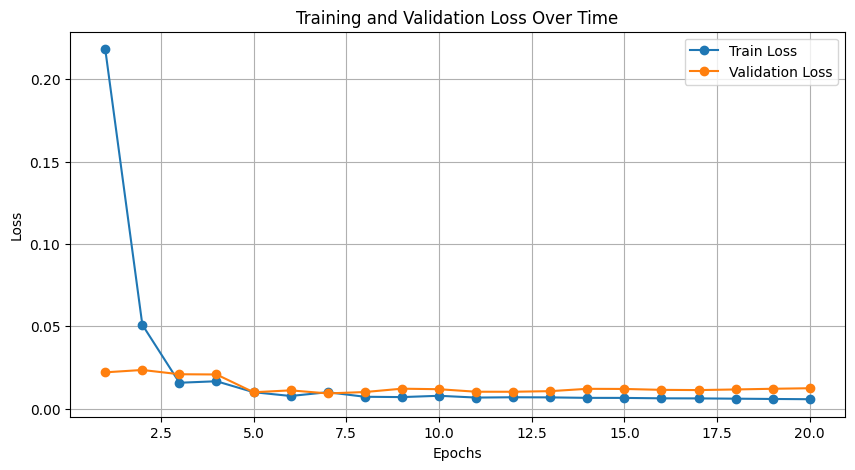

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o", label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def recommend_items(user_id, top_k=5):
    user_id_lower = user_id.strip().lower()  # Ensure case-insensitive matching
    
    if user_id_lower not in user_embeddings:
        print(f"User {user_id} not found!")
        return None
    
    user_emb = user_embeddings[user_id_lower].unsqueeze(0)
    scores = torch.cosine_similarity(model.user_tower(user_emb), model.item_tower(item_embeddings), dim=1)

    # Convert scores to a Pandas series for indexing
    scores_df = pd.Series(scores.detach().cpu().numpy(), index=df_items.index)

    # Debugging: Check if user's self-added items exist in the index
    if user_id_lower in user_added_items:
        to_remove = list(user_added_items[user_id_lower])
        print(f"🔹 Excluding self-added items for {user_id}: {to_remove}")
        scores_df = scores_df.drop(to_remove, errors="ignore")

    # Get top-k recommendations
    top_k_items = scores_df.nlargest(top_k).index
    return df_items.loc[top_k_items, ["brand", "name", "image_path"]]


In [ ]:
def show_recommendations(user_id, top_k=5):
    recommendations = recommend_items(user_id, top_k)
    
    if recommendations is None or recommendations.empty:
        print(f"❌ No recommendations found for User: {user_id}")
        return
    
    print(f"\n🔹 Top-{top_k} Recommendations for User: {user_id}\n")
    
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))

    for i, (_, row) in enumerate(recommendations.iterrows()):
        img_path = row["image_path"]
        
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['brand']}\n{row['name']}", fontsize=10)
            axes[i].axis("off")
        else:
            axes[i].set_title("Image Not Found", fontsize=10)
            axes[i].axis("off")

    plt.show()


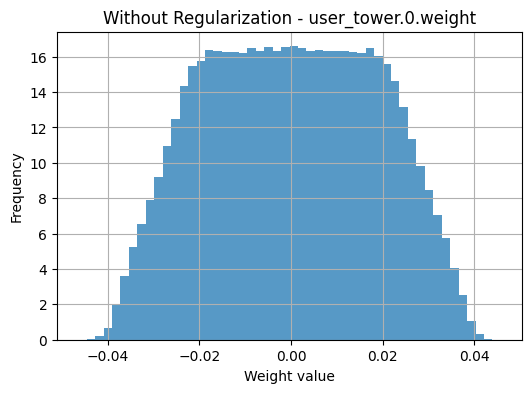

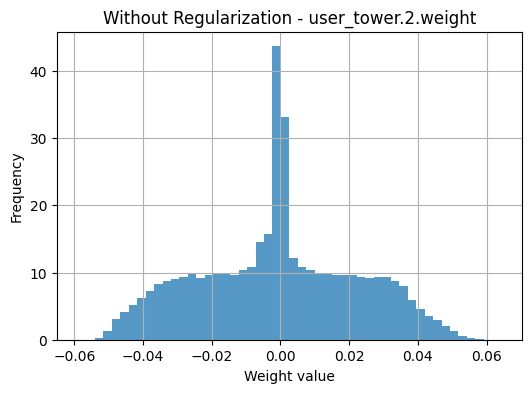

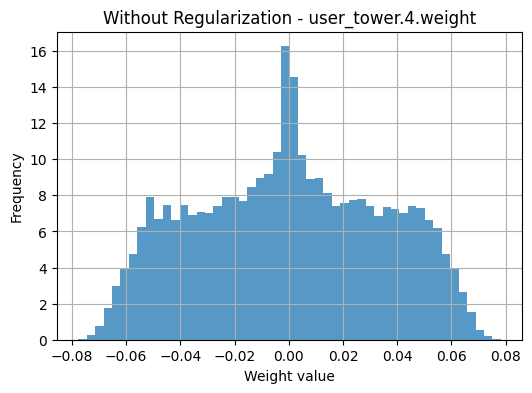

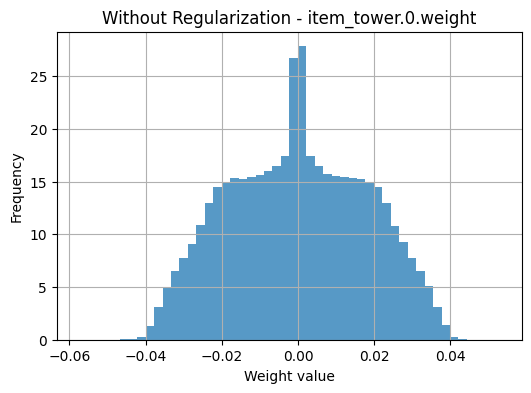

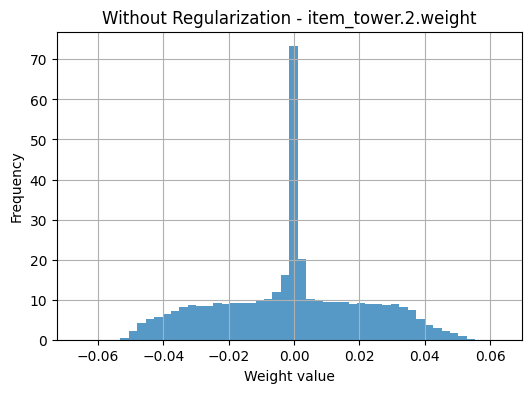

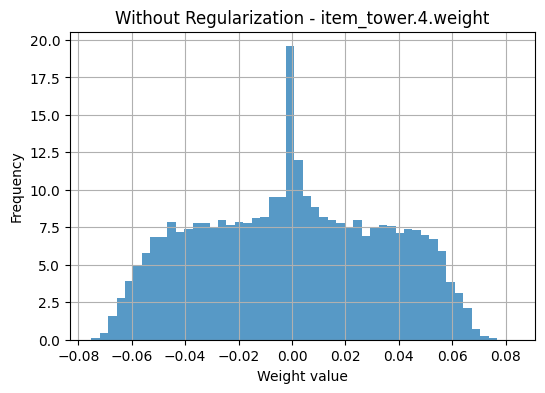

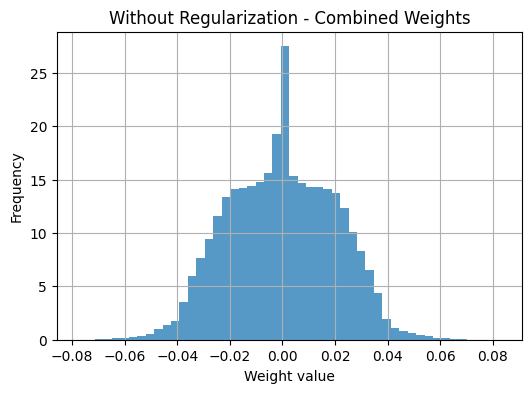

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_weight_histograms(model, title="Weight Histograms"):
    all_weights = []
    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            # Flatten the weights into a one-dimensional array
            weights = param.data.cpu().numpy().flatten()
            all_weights.append(weights)
            # Plot histogram for each layer
            plt.figure(figsize=(6, 4))
            plt.hist(weights, bins=50, density=True, alpha=0.75)
            plt.title(f"{title} - {name}")
            plt.xlabel("Weight value")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
    
    # Optionally, you could also plot the combined histogram:
    combined = np.concatenate(all_weights)
    plt.figure(figsize=(6, 4))
    plt.hist(combined, bins=50, density=True, alpha=0.75)
    plt.title(f"{title} - Combined Weights")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example usage:
# After training your model with regularization:
plot_weight_histograms(model, title="Without Regularization")

# For comparison, you might train another model without regularization,
# then call:
# plot_weight_histograms(model_no_reg, title="Without Regularization")



🔹 Top-5 Recommendations for User: matt



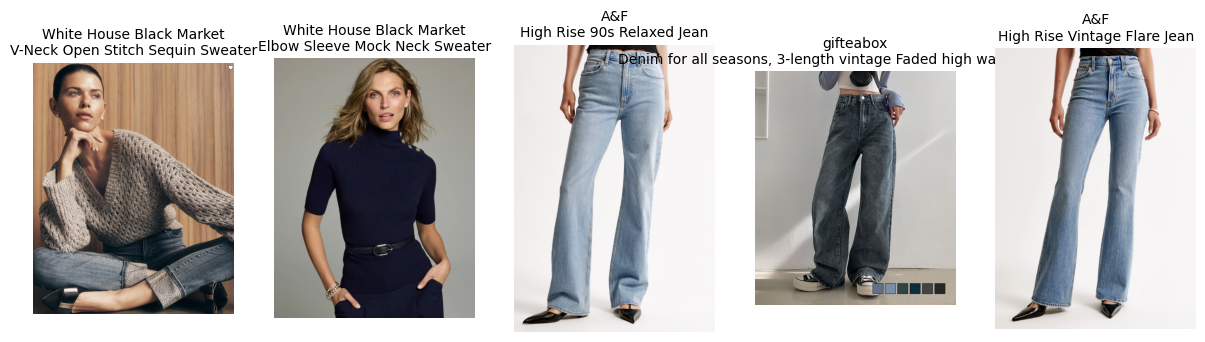


🔹 Top-5 Recommendations for User: laura



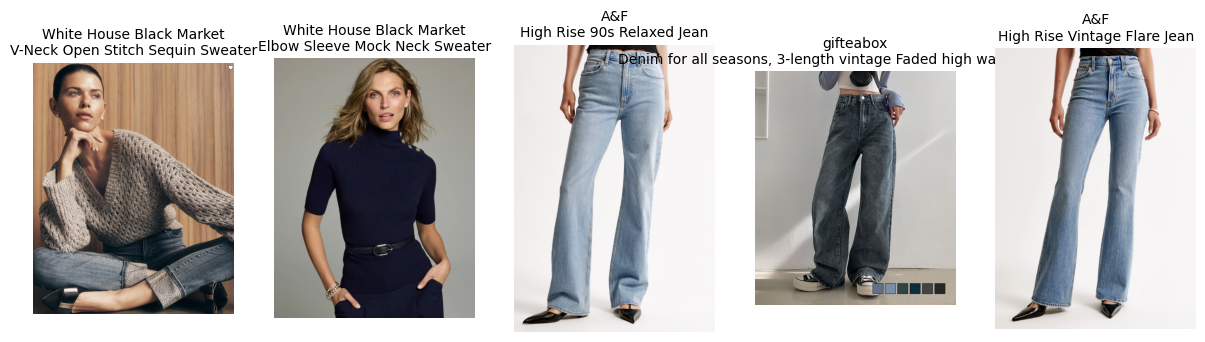


🔹 Top-5 Recommendations for User: megan



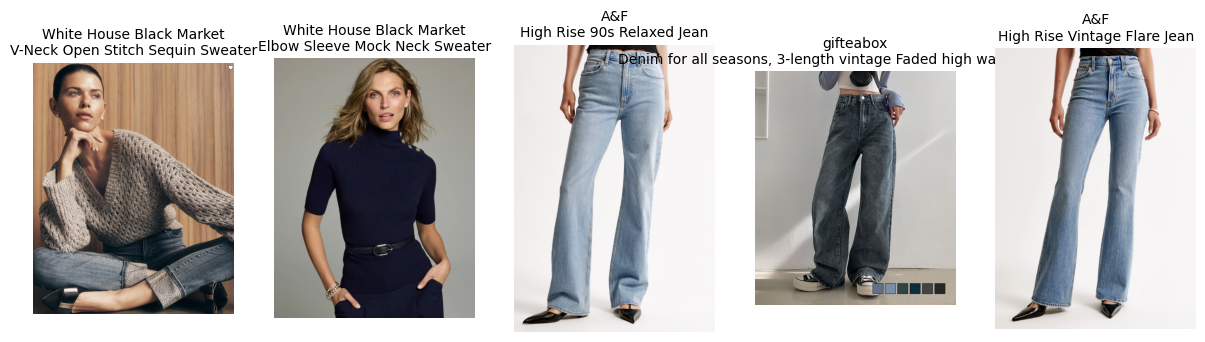


🔹 Top-5 Recommendations for User: vivian



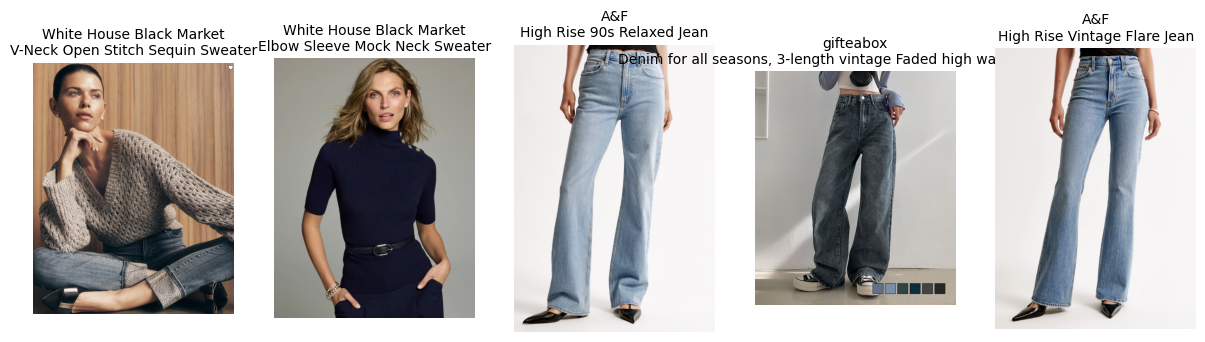


🔹 Top-5 Recommendations for User: brianna



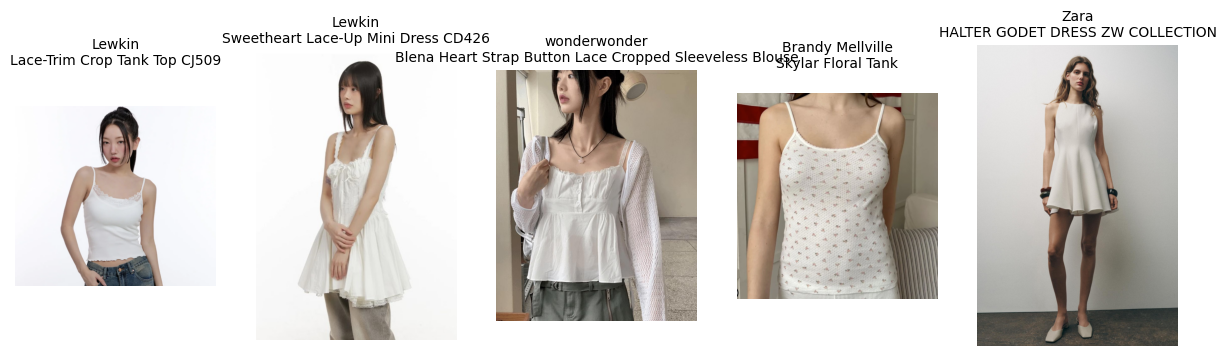


🔹 Top-5 Recommendations for User: sophia



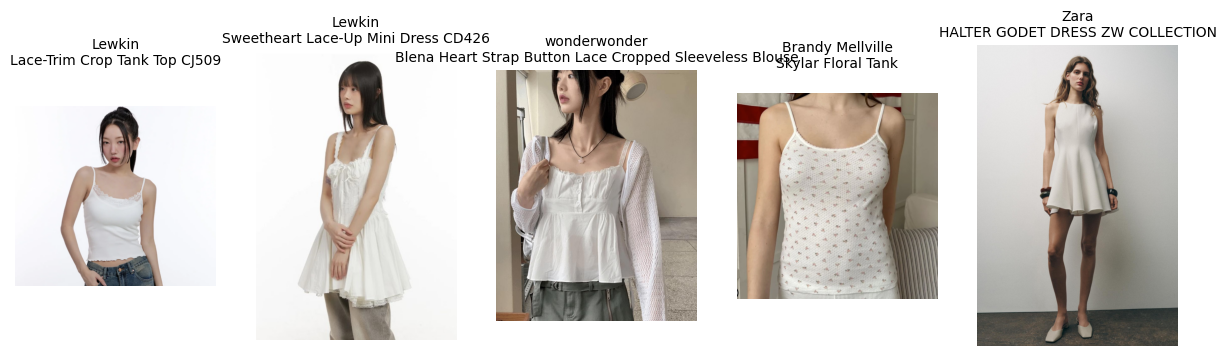


🔹 Top-5 Recommendations for User: jake



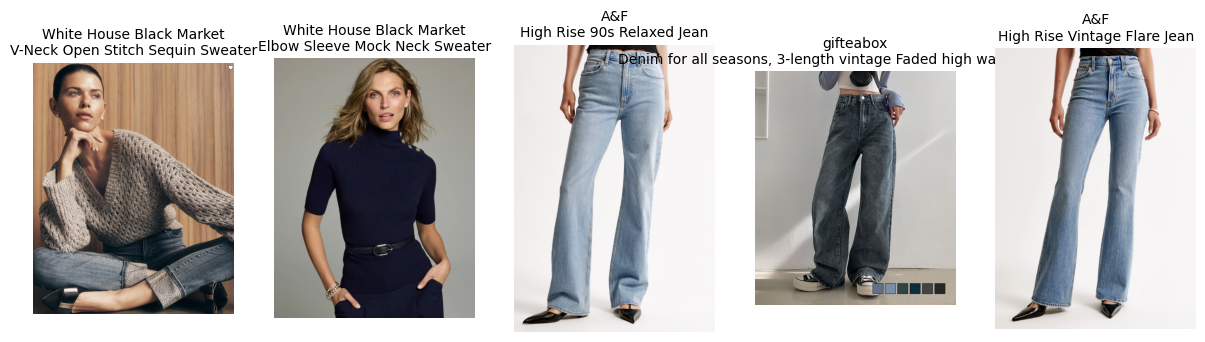


🔹 Top-5 Recommendations for User: lily



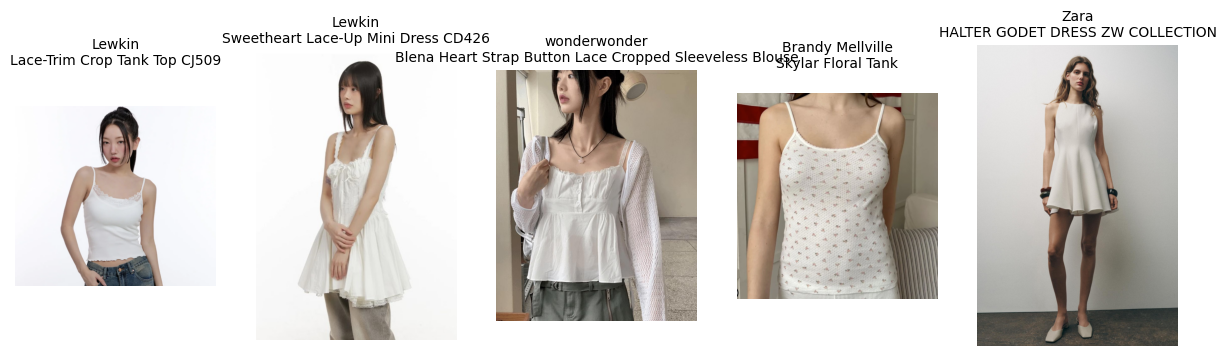


🔹 Top-5 Recommendations for User: alex



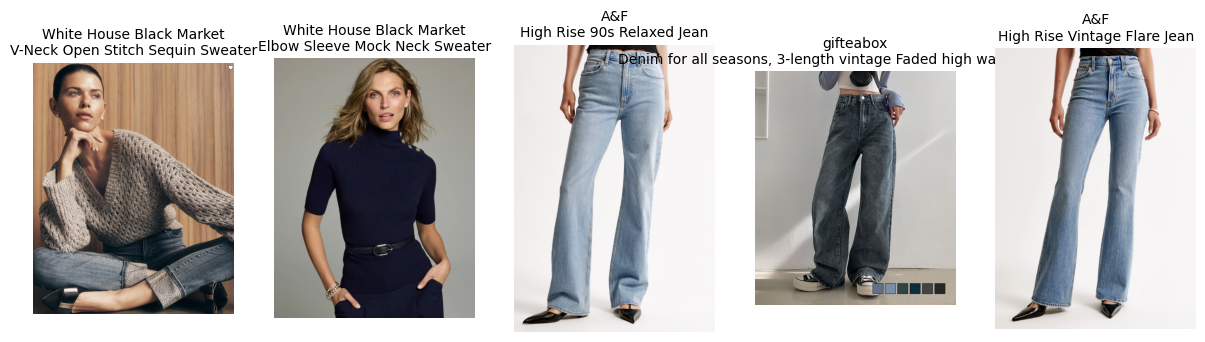


🔹 Top-5 Recommendations for User: emma



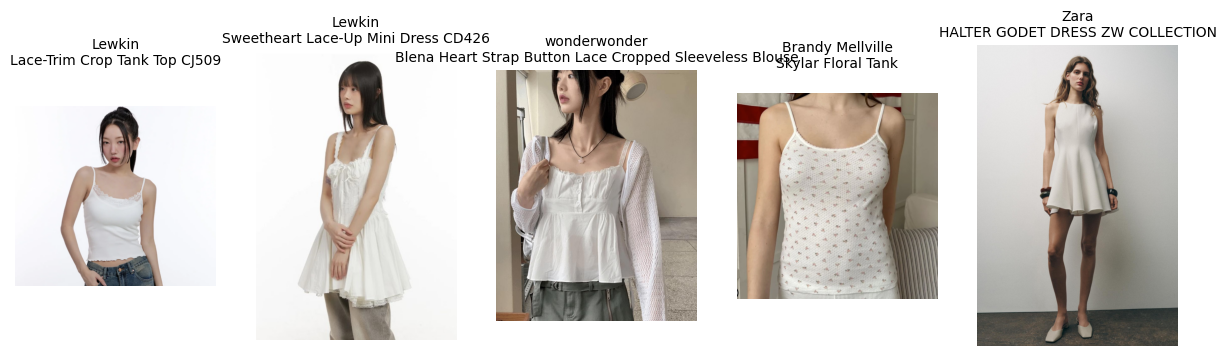


🔹 Top-5 Recommendations for User: user



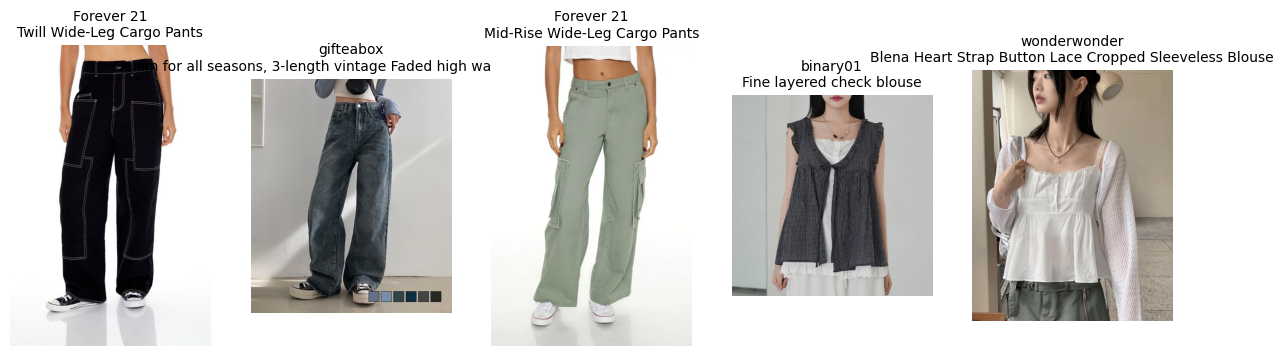

In [ ]:
for user_id in df_ratings.columns:
    show_recommendations(user_id, top_k=5)
